In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


## Loading

In [2]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

In [3]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot",
    "froze_ms_coefs_round": 50
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 64,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0000,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new2": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4,
      "mm_thres": 200
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 300,
            "learning_rate": 0.001,
            "weight_decay": 0.0,
            "pred_round": 500,
            "pred_local_epochs": 3,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [5]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def vis_mm_sim(mm_coefs, metric = 'cos'):
    n_cols = 5
    n_rows = (mm_coefs.shape[0] - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(mm_coefs.shape[0]):
        
        X = mm_coefs[feature_idx]
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("Mechanism Similarity")
    plt.tight_layout()
    plt.show()

In [6]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'
dataset = 'genetic'

# Subcase1 -  1 vs N Uneven Split LR

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-06 13:29:39.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:29:39.822 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:30:38.629 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:30:38.630 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:31:39.925 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:31:39.926 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:31:46.120 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 129.08541580010206


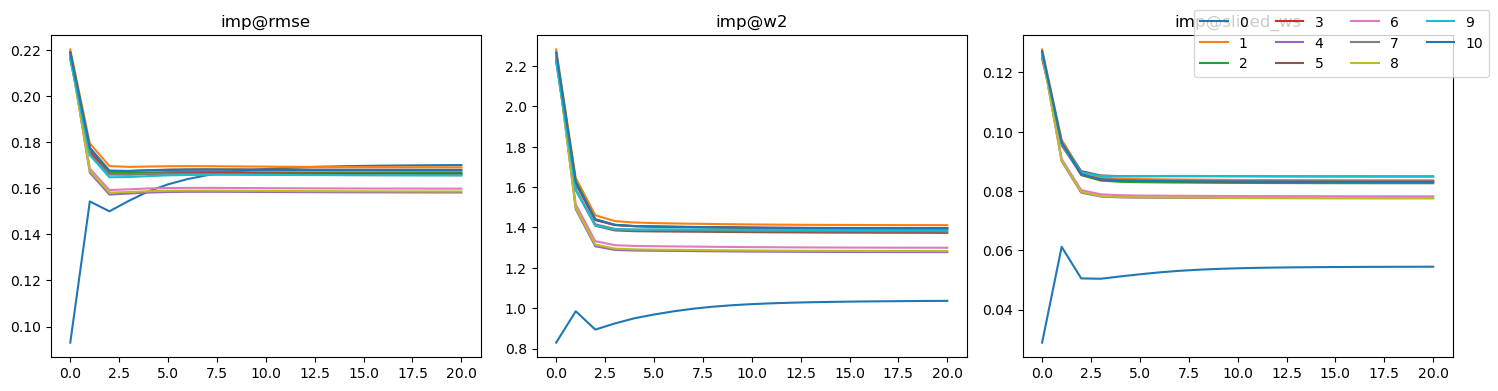

{'imp@rmse': 0.16496233447419403, 'imp@ws': 1.330503595438496, 'imp@sliced_ws': 0.0793929539559392}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mna

2023-11-06 13:31:59.129 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:31:59.129 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:32:55.086 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:32:55.087 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:33:57.300 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:33:57.301 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:34:03.740 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 127.35444499994628


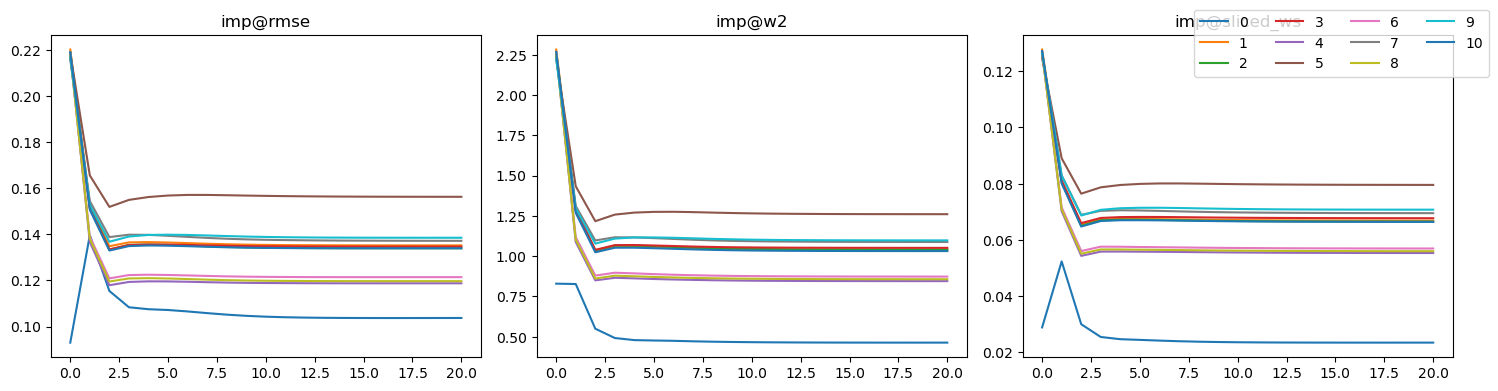

{'imp@rmse': 0.13026794540599845, 'imp@ws': 0.9678526427643492, 'imp@sliced_ws': 0.06172268934112419}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'm

2023-11-06 13:34:16.886 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:34:16.887 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:35:12.480 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:35:12.481 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:36:14.063 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:36:14.064 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:36:20.266 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 126.14421090018004


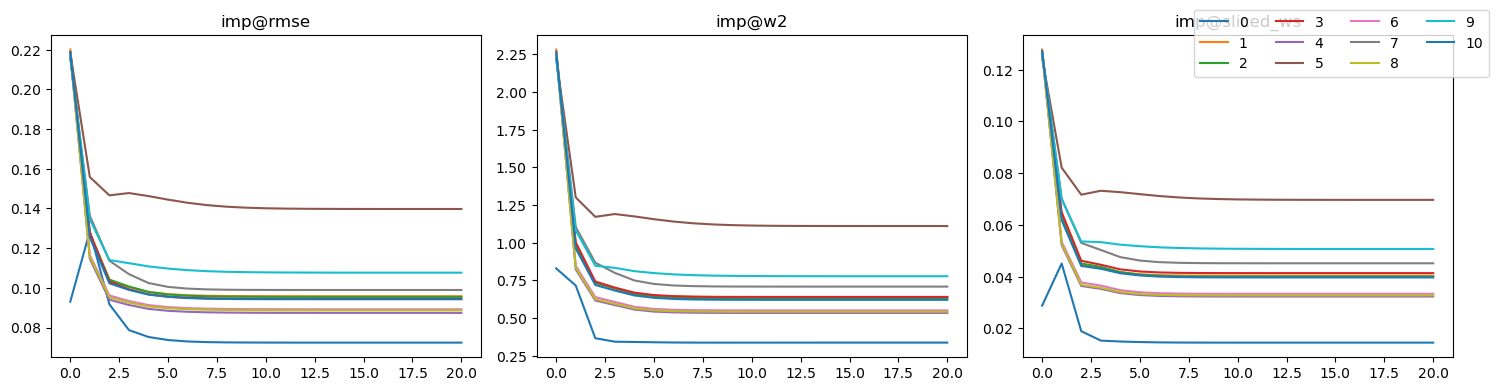

{'imp@rmse': 0.09671841130861847, 'imp@ws': 0.6445594024375909, 'imp@sliced_ws': 0.040010299161734555}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', '

2023-11-06 13:36:33.344 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:36:33.345 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:37:29.396 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:37:29.397 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:38:32.541 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:38:32.541 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:38:38.810 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 128.22524369996972


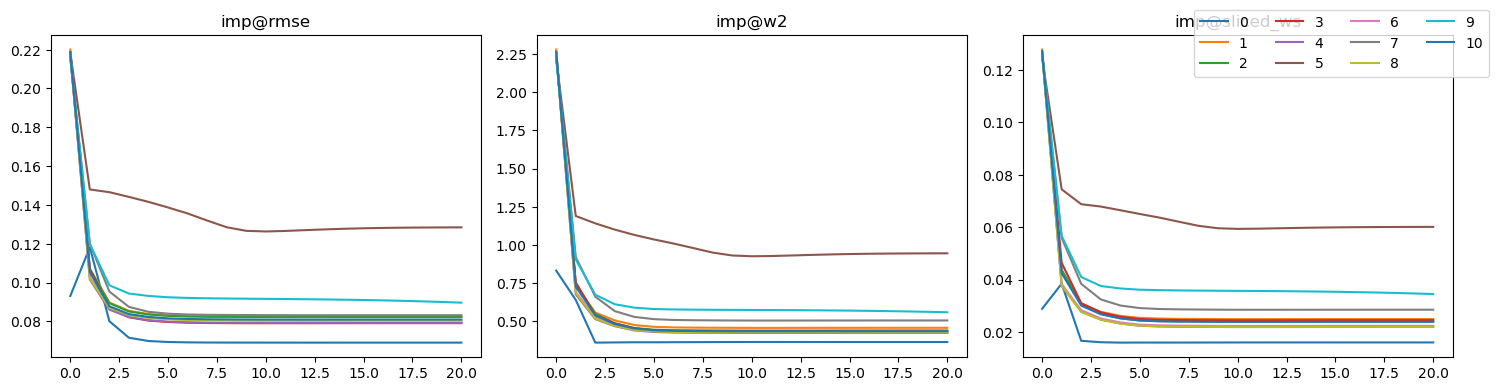

{'imp@rmse': 0.08505628330499548, 'imp@ws': 0.4894830588505141, 'imp@sliced_ws': 0.0275239300355969}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mn

2023-11-06 13:38:51.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:38:51.984 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:39:48.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:39:48.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:40:50.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:40:50.556 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:40:56.952 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 127.76873010001145


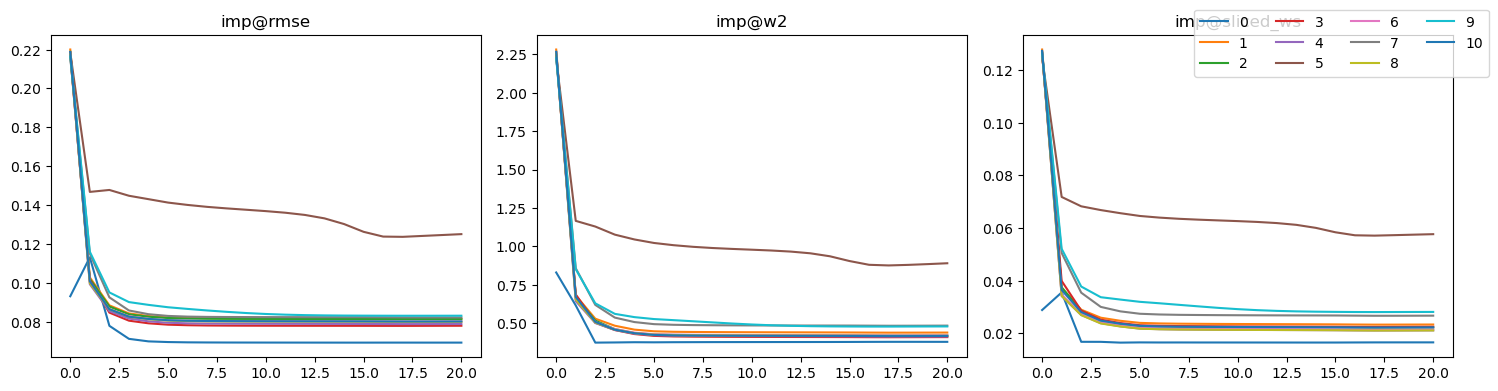

{'imp@rmse': 0.0834343010268504, 'imp@ws': 0.46752161937158637, 'imp@sliced_ws': 0.02566325678837833}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'm

2023-11-06 13:41:10.099 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:41:10.100 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:42:07.006 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:42:07.007 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:43:10.863 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:43:10.864 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:43:17.271 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 129.95061029982753


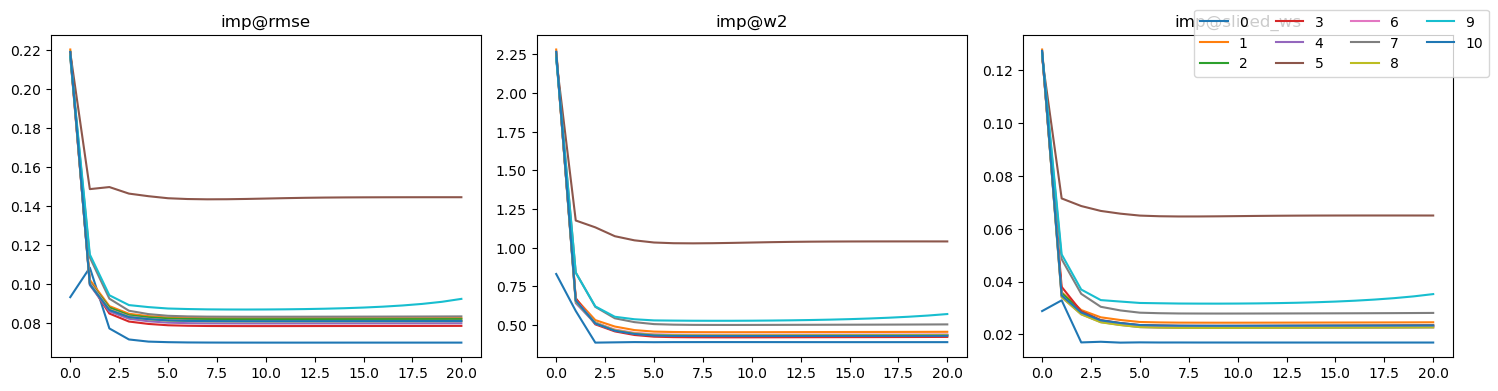

{'imp@rmse': 0.08647919194426715, 'imp@ws': 0.5021697045927858, 'imp@sliced_ws': 0.02785812125636781}
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(20000, 25)
(18000, 25) (2000, 25)
(18000, 25)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'm

2023-11-06 13:43:30.403 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:43:30.403 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 13:44:27.213 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:44:27.213 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 13:45:30.113 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 13:45:30.114 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 13:45:36.438 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 128.80496929981746


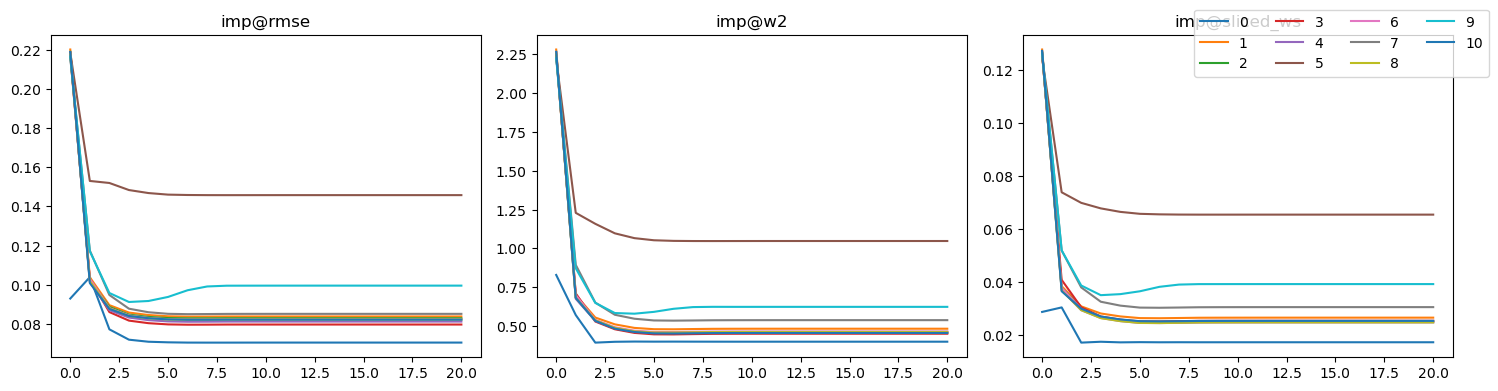

{'imp@rmse': 0.08874920685959513, 'imp@ws': 0.5310626003708917, 'imp@sliced_ws': 0.030057061578644823}


In [21]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-unevendirl1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

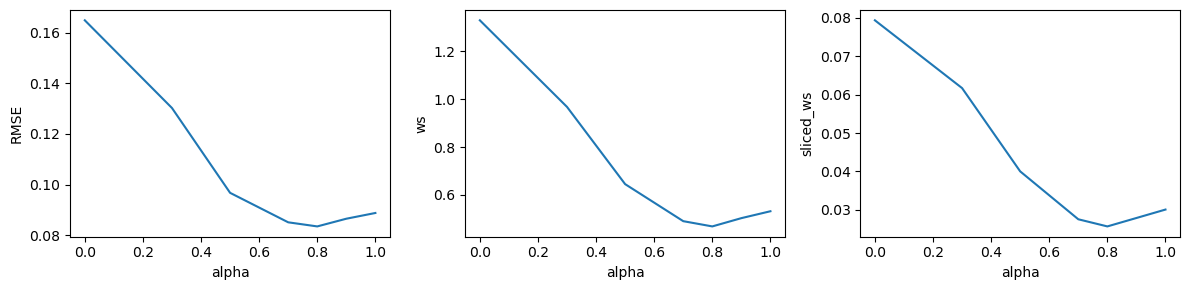

In [22]:
x = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase 2 - 1 vs N Uevenly Split RL

Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:26:29.482 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:26:29.483 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:27:54.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:27:54.351 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:29:23.548 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:29:23.549 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:29:32.441 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 185.84070160000192


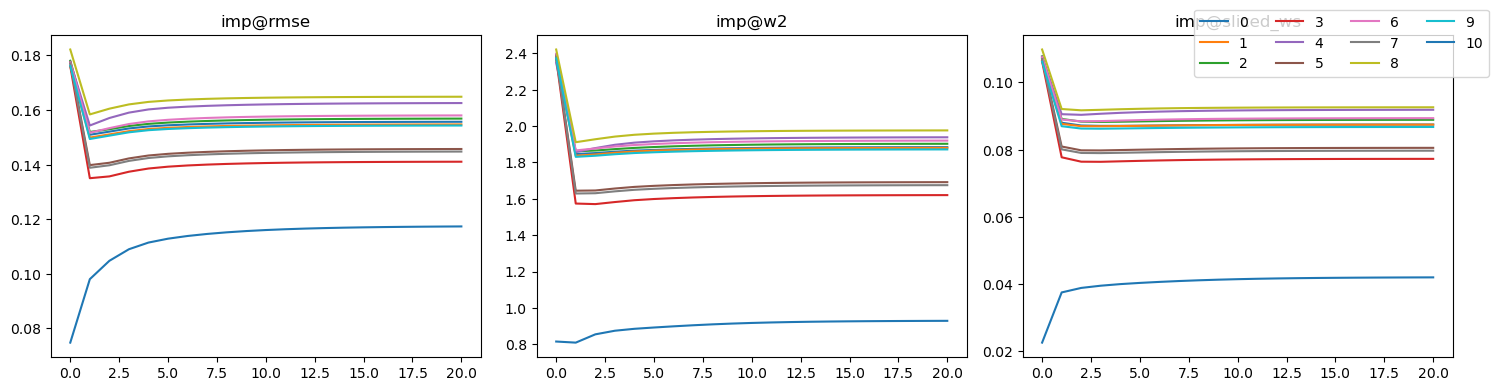

{'imp@rmse': 0.15048671083814918, 'imp@ws': 1.753315487476827, 'imp@sliced_ws': 0.08214109764725139}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:29:39.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:29:39.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:30:57.745 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:30:57.745 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:32:21.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:32:21.543 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:32:30.019 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 173.2659437000002


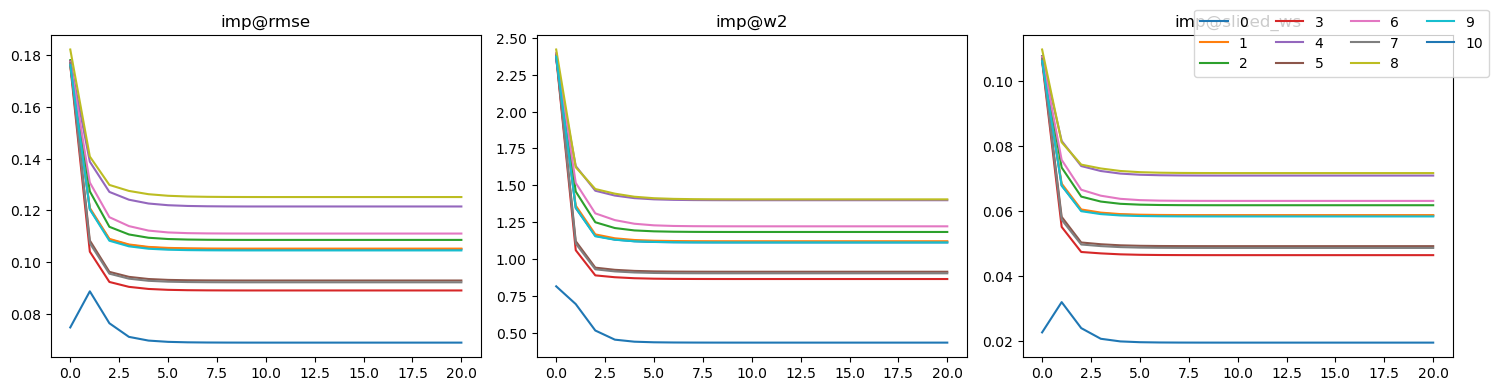

{'imp@rmse': 0.10219479607066832, 'imp@ws': 1.0609977704228652, 'imp@sliced_ws': 0.055166166600979116}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:32:37.331 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:32:37.332 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:33:55.992 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:33:55.993 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:35:22.851 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:35:22.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:35:31.826 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 177.67257510000127


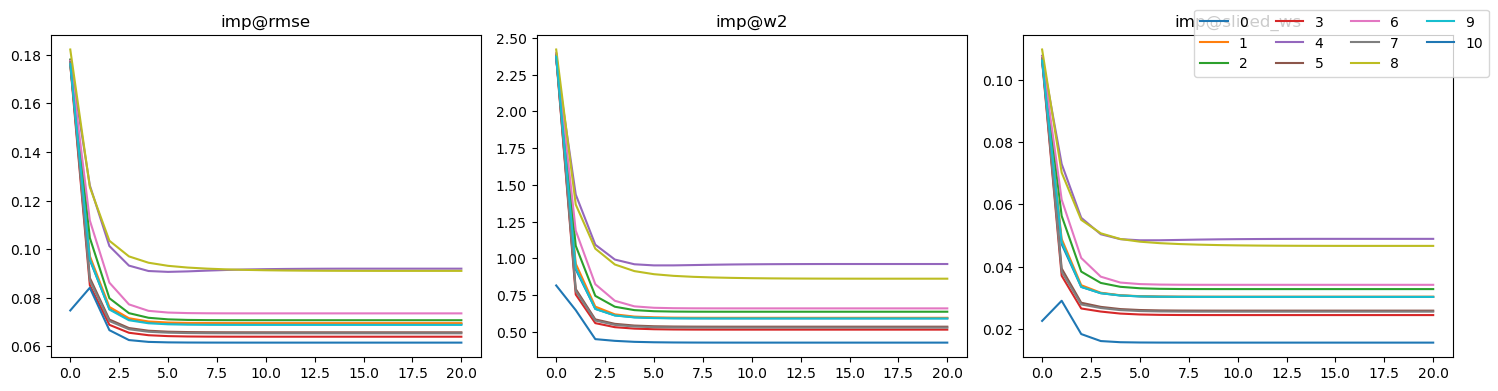

{'imp@rmse': 0.0719741037196962, 'imp@ws': 0.626946826893899, 'imp@sliced_ws': 0.03138443485256551}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:35:39.205 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:35:39.206 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:36:59.200 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:36:59.201 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:38:25.575 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:38:25.576 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:38:34.284 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 178.24420219999956


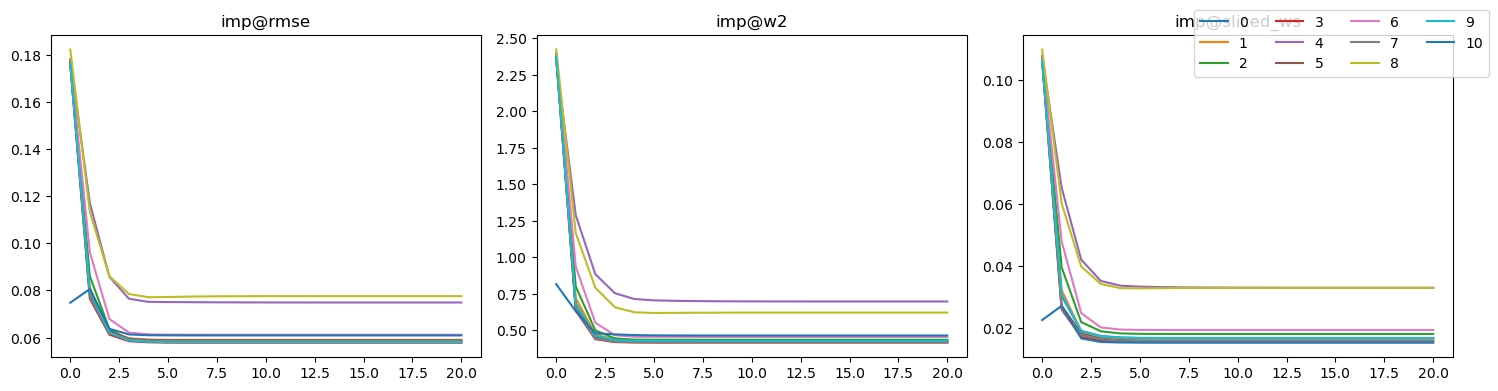

{'imp@rmse': 0.06213730913941653, 'imp@ws': 0.47299726484646015, 'imp@sliced_ws': 0.01968776224720193}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:38:42.144 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:38:42.145 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:40:02.089 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:40:02.090 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:41:26.858 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:41:26.858 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:41:35.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 177.10277190000124


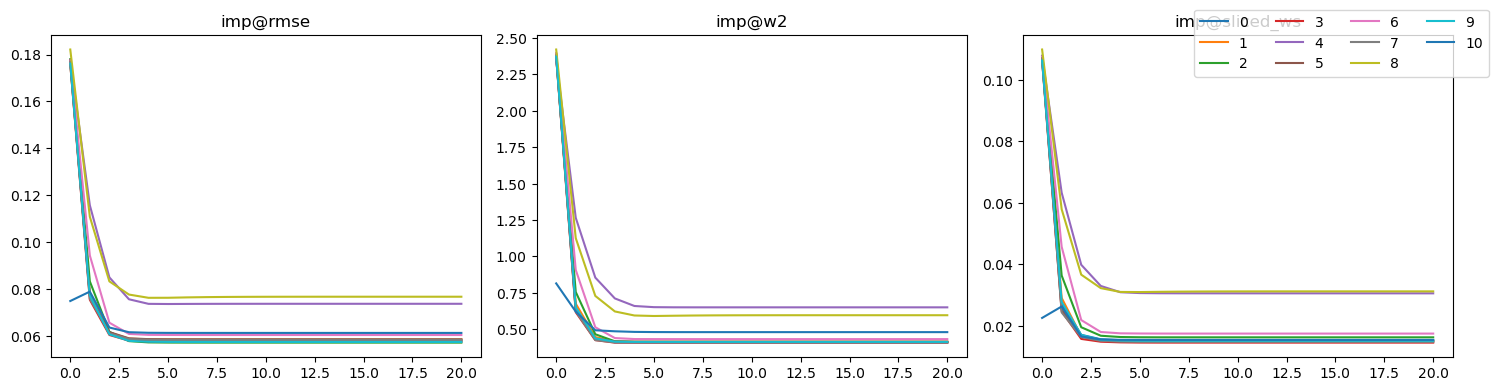

{'imp@rmse': 0.06148271916757381, 'imp@ws': 0.45835536305688573, 'imp@sliced_ws': 0.018282021213370497}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:41:43.393 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:41:43.394 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:43:07.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:43:07.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:44:36.245 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:44:36.246 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:44:44.992 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 184.68805829999837


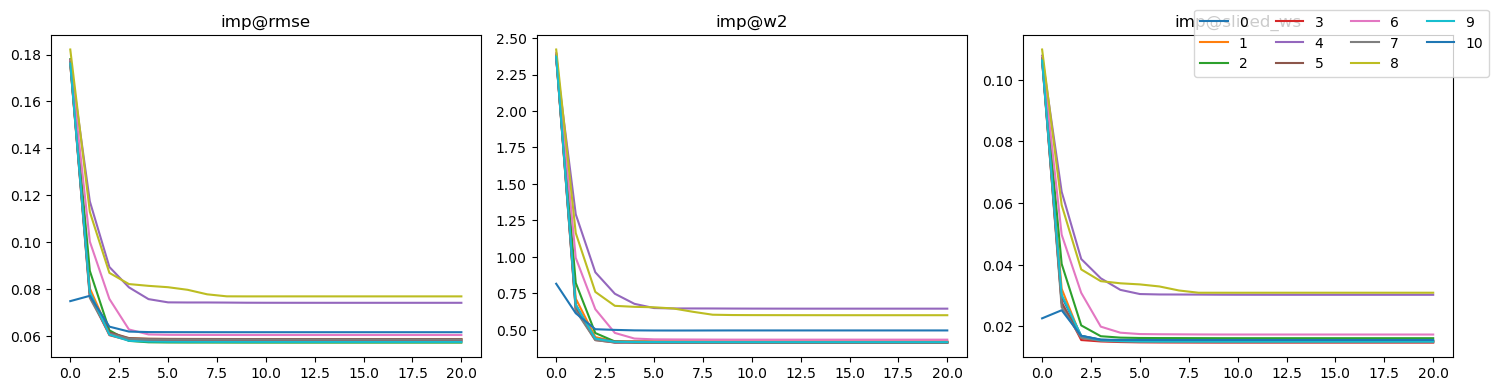

{'imp@rmse': 0.06167794652706006, 'imp@ws': 0.4605820731748027, 'imp@sliced_ws': 0.018227423460060226}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:44:52.519 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:44:52.519 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:46:12.979 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:46:12.980 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 22:47:42.322 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:47:42.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 22:47:51.508 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 182.18097829999897


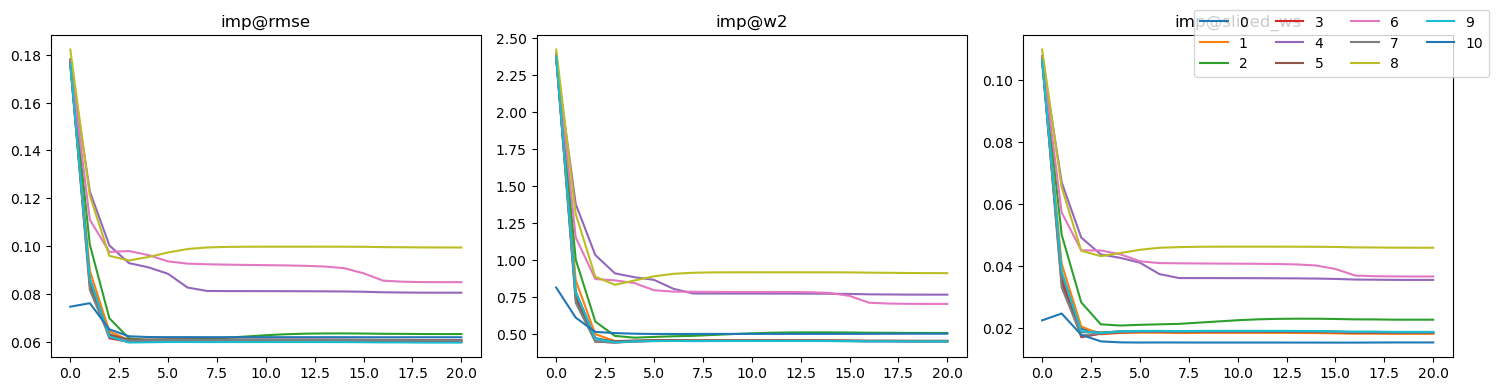

{'imp@rmse': 0.06846709807617833, 'imp@ws': 0.5566186965240789, 'imp@sliced_ws': 0.02443463510076009}


In [7]:
results_compl_alpha = []

for alpha in [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
    config2['data_partition']['strategy'] = 'sample-unevendirr1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

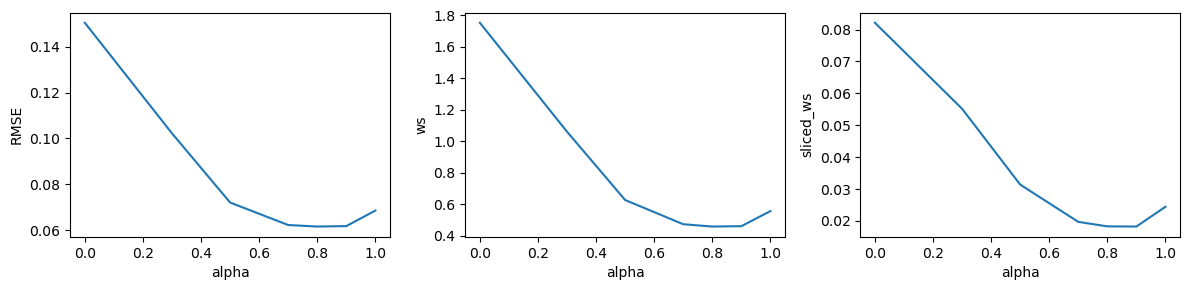

In [8]:
x = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase2 - 2 clusters

Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-uneven10 {}
sample sizes:  [482, 290, 1204, 1571, 14453, 110, 414, 1455, 1919, 14103]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-06 22:53:49.362 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:53:49.363 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 22:57:20.167 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 22:57:20.168 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 23:01:21.138 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:01:21.139 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 23:01:45.268 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 482.73570090000067


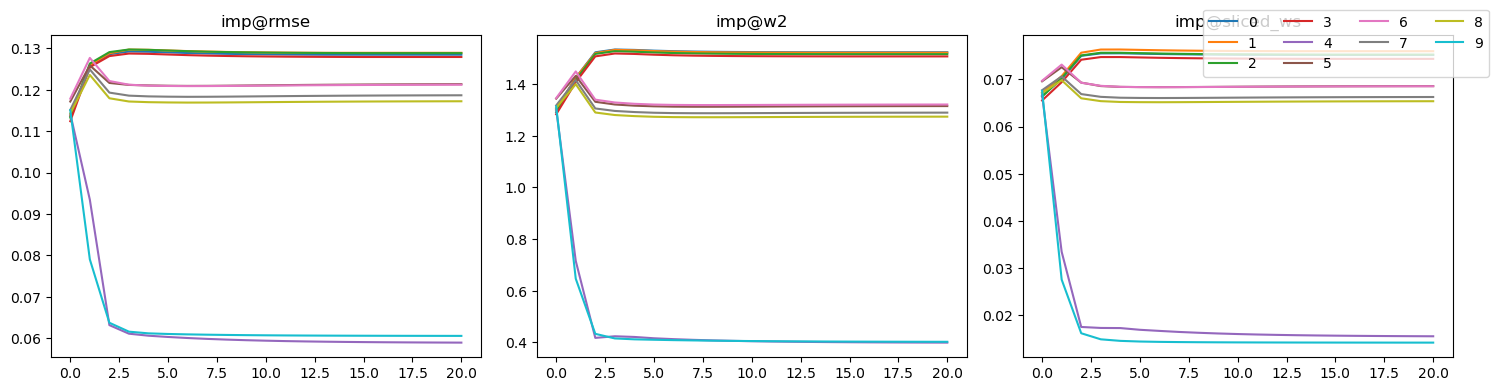

{'imp@rmse': 0.11118573199010565, 'imp@ws': 1.2064042526837708, 'imp@sliced_ws': 0.05992348207250597}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-uneven10 {}
sample sizes:  [482, 290, 1204, 1571, 14453, 110, 414, 1455, 1919, 14103]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-06 23:01:58.017 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:01:58.018 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 23:05:30.244 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:05:30.245 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-06 23:09:26.764 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:09:26.765 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-06 23:09:51.386 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 481.6509561999992


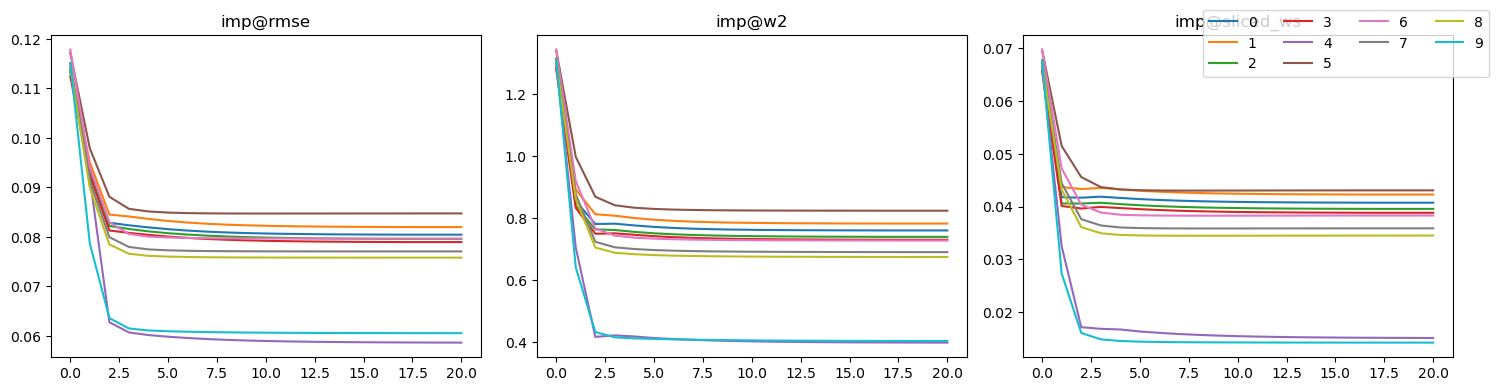

{'imp@rmse': 0.07576106887524055, 'imp@ws': 0.6734232382348689, 'imp@sliced_ws': 0.03424754983124733}
Index(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE',
       'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'],
      dtype='object')
(65188, 217)
(65188, 12)
(65188, 230)
(20000, 33)
CLASS
0    15007
1     4993
Name: count, dtype: int64
(18000, 33) (2000, 33)
(18000, 33)
sample-uneven10 {}
sample sizes:  [482, 290, 1204, 1571, 14453, 110, 414, 1455, 1919, 14103]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-06 23:10:03.923 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:10:03.924 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-06 23:13:41.151 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-06 23:13:41.152 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10


KeyboardInterrupt: 

In [9]:
results_compl_alpha = []
for alpha in [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'sample-uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

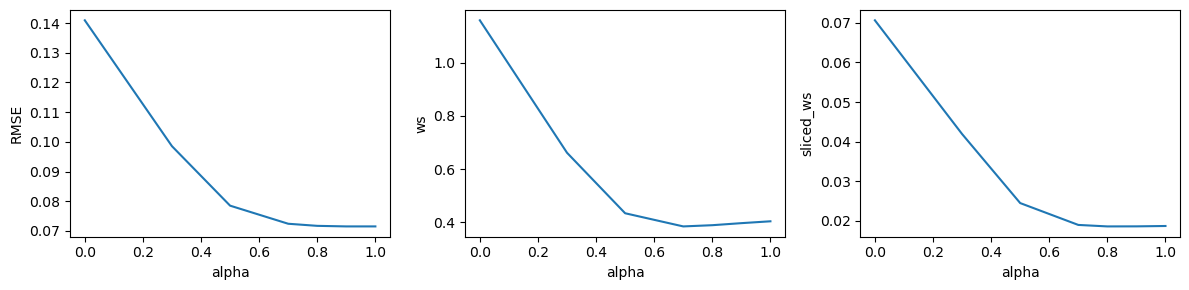

In [ ]:
x = [0.0, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.31724148632788224
# ws = 1.0327202461435718
# sliced_ws = 0.1650482253637849
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# end